In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.api as sm
from datetime import datetime
import requests
from io import BytesIO
%matplotlib inline

In [2]:
class StateSpace(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 3

        # Initialize the statespace
        super(StateSpace, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )
        
        #self.k_endog = endog.shape[0]
        self.k_endog = 1
        self.nobs = endog.shape[0]
        self.k_states = k_states
        self.k_posdef = k_posdef

        # Initialize the fixed matrices
        self.ssm['selection'] = np.eye(self.k_posdef)
        self.ssm['obs_intercept'] = np.zeros((self.k_endog,))
        self.ssm['state_intercept'] = np.zeros((self.k_states,))

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(self.k_posdef)
        self._obs_cov_idx = ('obs_cov',) + np.diag_indices(self.k_endog)


    @property
    def param_names(self):
        return ['Z_00','Z_01','Z_02',
                'T_00','T_01','T_02',
                'T_10','T_11','T_12',
                'T_20','T_21','T_22',
                'H_0',
                'Q_0','Q_1','Q_2']

    @property
    def start_params(self):
        z_arr = np.random.normal(size=(self.k_endog*self.k_states))
        t_arr = np.random.normal(size=(self.k_states*self.k_states)).flatten()
        h_diag = 0.001*np.ones(self.k_endog) #obs cov
        q_diag = 0.001*np.ones(self.k_states) # state cov
        return np.concatenate((z_arr,t_arr,h_diag,q_diag))

    
    def transform_params(self, unconstrained):
        return np.concatenate((unconstrained[0:3+3*self.k_states],unconstrained[3+3*self.k_states:]**2))

    def untransform_params(self, constrained):
        return np.concatenate((constrained[0:3+3*self.k_states],constrained[3+3*self.k_states:]**0.5))
    

    def update(self, params, *args, **kwargs):
        params = super(StateSpace, self).update(params, *args, **kwargs)
        
        # Design matrix covariance
        self.ssm['design',0,0] = params[0]
        self.ssm['design',0,1] = params[1]
        self.ssm['design',0,2] = params[2]
        
        # Transition matrix
        self.ssm['transition',0,:] = params[3:3+self.k_states]
        self.ssm['transition',1,:] = params[3+self.k_states:3+2*self.k_states]
        self.ssm['transition',2,:] = params[3+2*self.k_states:3+3*self.k_states]

        # Observed covariance - fix to diagonal
        self.ssm[self._obs_cov_idx]= params[3+3*self.k_states:3+3*self.k_states+self.k_endog]
        
        # State covariance - fix to diagonal
        self.ssm[self._state_cov_idx] = params[3+3*self.k_states+self.k_endog:3+3*self.k_states+self.k_endog+self.k_states]

In [3]:
#Simulate data
k_endog = 1 # dimensions of y
k_states = 3
k_posedef = k_states
#Z= [[1,0,0.0],[0.3,-0.2,0.001]]
Z= [[1,0.5,1]]
T = [[0.1,0.1,1],[0.2,0,0.4],[0,1,0.2]]
time_period= 1000
Epsilon = np.random.normal(0,0.01,[k_endog,time_period])
Eta = np.random.normal(0,0.01,[k_posedef,time_period])
alpha_0 = np.random.randn((k_states))

In [4]:
y = np.zeros((k_endog,time_period))
Alpha = np.zeros((k_states,time_period))
for t in range(time_period):
    if t>0:
        Alpha[:,t] = np.matmul(T,Alpha[:,t-1]) + Eta[:,t]
    y[:,t] = np.matmul(Z,Alpha[:,t]) + Epsilon[:,t]

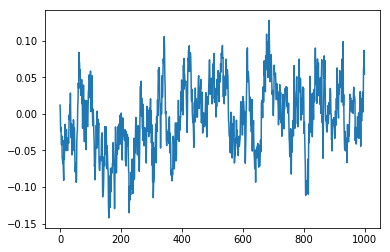

In [5]:
plt.plot(y[0,:])

In [6]:
# Setup the model
mod = StateSpace(y[0,:])

# Fit it using MLE (recall that we are fitting the three variance parameters)
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                     StateSpace   Log Likelihood                2351.203
Date:                Wed, 04 Sep 2019   AIC                          -4670.407
Time:                        14:36:53   BIC                          -4591.931
Sample:                             0   HQIC                         -4640.576
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Z_00          -0.9236   1.46e-07  -6.32e+06      0.000      -0.924      -0.924
Z_01           1.3830   1.87e-07   7.39e+06      0.000       1.383       1.383
Z_02          -0.7702   1.68e-07  -4.58e+06      0.0

/h/shalmali/anaconda3/envs/tsx/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


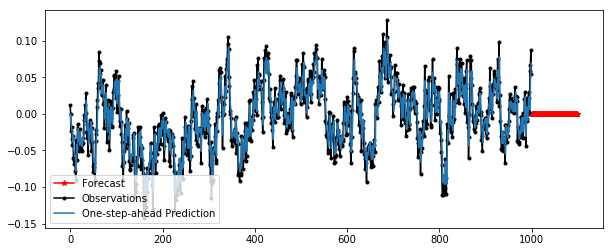

In [48]:
predict = res.get_prediction()
tt=100
forecast = res.get_forecast(time_period+tt)
fig, ax = plt.subplots(figsize=(10,4))

# Plot the results
plt.plot(range(time_period,time_period+tt),forecast.predicted_mean[-tt:], color='r',marker='*', label='Forecast')
plt.plot(y[0,:], color='k',marker='.',label='Observations')
plt.plot(predict.predicted_mean, label='One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
#plt.fill_between(predict_index[2:], predict_ci[2:, 0], predict_ci[2:, 1], alpha=0.1)


#forecast_ci = forecast.conf_int()
#forecast_index = np.arange(len(predict_ci), len(predict_ci) + len(forecast_ci))
#ax.fill_between(forecast_index, forecast_ci[:, 0], forecast_ci[:, 1], alpha=0.1)

# Cleanup the image
#ax.set_ylim((4, 8))
legend = ax.legend(loc='lower left')